# Trabajo Práctico: Predicción de Gastos de Clientes durante Black Sales

- a) Analizar y preparar el dataset.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).
- b) Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`.** . Graficar las evoluciones de la funcion de costo y la metrica de validacion. Usar capas de regularizacion en caso de considerar necesario. Explicar resultados obtenidos.
- c)	Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Usar capas de regularizacion en caso de considerar necesario. Explicar resultados obtenidos.
- d) Para el modelo del punto c) implementar una funcion que a reciba un id de usuario y sugiera **n** cantidad usuarios que tuvieron un comportamiento de compras similar.

Para el punto e) vamos a considerar un problema de regresion, donde la salida es cuanto gasto el cliente:
- e)	Entrenar un de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Usar capas de regularizacion en caso de considerar necesario. Explicar resultados obtenidos.
- f) Para el mejor modelo obtenido en el apartado d) elegir al menos 2 hiperparametros para tunear. Explicar el metodo utilizado y los resultados obtenidos.



Este notebook contiene la solución a los puntos b), c) y d) del trabajo práctico.
El objetivo es predecir cuánto un cliente está dispuesto a gastar, utilizando deep learning.


In [1]:
#IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Cargar el dataset
dataset = pd.read_csv('./dataset_black_sales.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [4]:
# Preprocesar las columnas categóricas
label_encoder_gender = LabelEncoder()
dataset['Gender'] = label_encoder_gender.fit_transform(dataset['Gender'])

# One-hot encoding para la columna 'Age'
age_dummies = pd.get_dummies(dataset['Age'], prefix='Age')
dataset = pd.concat([dataset, age_dummies], axis=1)

# Eliminar la columna original 'Age'
dataset.drop('Age', axis=1, inplace=True)

# One-hot encoding para la columna 'City_Category'
city_dummies = pd.get_dummies(dataset['City_Category'], prefix='City')
dataset = pd.concat([dataset, city_dummies], axis=1)

# Eliminar la columna original 'City_Category'
dataset.drop('City_Category', axis=1, inplace=True)

# One-hot encoding para la columna 'Stay_In_Current_City_Years'
stay_in_city_dummies = pd.get_dummies(dataset['Stay_In_Current_City_Years'], prefix='Stay_In_City')
dataset = pd.concat([dataset, stay_in_city_dummies], axis=1)

# Eliminar la columna original 'Stay_In_Current_City_Years'
dataset.drop('Stay_In_Current_City_Years', axis=1, inplace=True)

# Imputar valores faltantes en Product_Category_2 y Product_Category_3
dataset['Product_Category_2'] = dataset['Product_Category_2'].fillna(0)
dataset['Product_Category_3'] = dataset['Product_Category_3'].fillna(0)

# Categorización de la columna Purchase
def categorize_purchase(purchase):
    if purchase < 5000:
        return 0
    elif 5000 <= purchase < 10000:
        return 1
    elif 10000 <= purchase < 15000:
        return 2
    else:
        return 3

# Crear la columna de categorías
dataset['Purchase_Category'] = dataset['Purchase'].apply(categorize_purchase)

In [5]:
# Mostrar las primeras filas del dataset actualizado
dataset.head()

,User_ID,Product_ID,Gender,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Age_0-17,...,Age_55+,City_A,City_B,City_C,Stay_In_City_0,Stay_In_City_1,Stay_In_City_2,Stay_In_City_3,Stay_In_City_4+,Purchase_Category
0,1000001,P00069042,0,10,0,3,0.0,0.0,8370,True,...,False,True,False,False,False,False,True,False,False,1
1,1000001,P00248942,0,10,0,1,6.0,14.0,15200,True,...,False,True,False,False,False,False,True,False,False,3
2,1000001,P00087842,0,10,0,12,0.0,0.0,1422,True,...,False,True,False,False,False,False,True,False,False,0
3,1000001,P00085442,0,10,0,12,14.0,0.0,1057,True,...,False,True,False,False,False,False,True,False,False,0
4,1000002,P00285442,1,16,0,8,0.0,0.0,7969,False,...,True,False,False,True,False,False,False,False,True,1


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   User_ID             550068 non-null  int64  
 1   Product_ID          550068 non-null  object 
 2   Gender              550068 non-null  int32  
 3   Occupation          550068 non-null  int64  
 4   Marital_Status      550068 non-null  int64  
 5   Product_Category_1  550068 non-null  int64  
 6   Product_Category_2  550068 non-null  float64
 7   Product_Category_3  550068 non-null  float64
 8   Purchase            550068 non-null  int64  
 9   Age_0-17            550068 non-null  bool   
 10  Age_18-25           550068 non-null  bool   
 11  Age_26-35           550068 non-null  bool   
 12  Age_36-45           550068 non-null  bool   
 13  Age_46-50           550068 non-null  bool   
 14  Age_51-55           550068 non-null  bool   
 15  Age_55+             550068 non-nul

In [7]:
# Punto b) - Modelo de deep learning sin embeddings
# Preprocesamiento y creación del modelo sin embeddings

# Seleccionar las columnas relevantes
X = dataset.drop(columns=['User_ID', 'Product_ID','Purchase','Purchase_Category'])

# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Definir variable objetivo
y = dataset['Purchase_Category']

# Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Epoch 1/100, Train Loss: 0.9966, Train Accuracy: 60.60%, Val Loss: 0.9199, Val Accuracy: 63.70%
Epoch 2/100, Train Loss: 0.9128, Train Accuracy: 64.33%, Val Loss: 0.8313, Val Accuracy: 68.65%
Epoch 3/100, Train Loss: 0.8689, Train Accuracy: 66.02%, Val Loss: 0.7982, Val Accuracy: 69.26%
Epoch 4/100, Train Loss: 0.8448, Train Accuracy: 66.83%, Val Loss: 0.7804, Val Accuracy: 69.45%
Epoch 5/100, Train Loss: 0.8265, Train Accuracy: 67.46%, Val Loss: 0.7707, Val Accuracy: 69.98%
Epoch 6/100, Train Loss: 0.8187, Train Accuracy: 67.89%, Val Loss: 0.7589, Val Accuracy: 70.58%
Epoch 7/100, Train Loss: 0.8092, Train Accuracy: 68.26%, Val Loss: 0.7583, Val Accuracy: 70.80%
Epoch 8/100, Train Loss: 0.8049, Train Accuracy: 68.35%, Val Loss: 0.7561, Val Accuracy: 70.37%
Epoch 9/100, Train Loss: 0.8009, Train Accuracy: 68.49%, Val Loss: 0.7550, Val Accuracy: 70.62%
Epoch 10/100, Train Loss: 0.7985, Train Accuracy: 68.57%, Val Loss: 0.7490, Val Accuracy: 70.78%
Epoch 11/100, Train Loss: 0.7970, Train

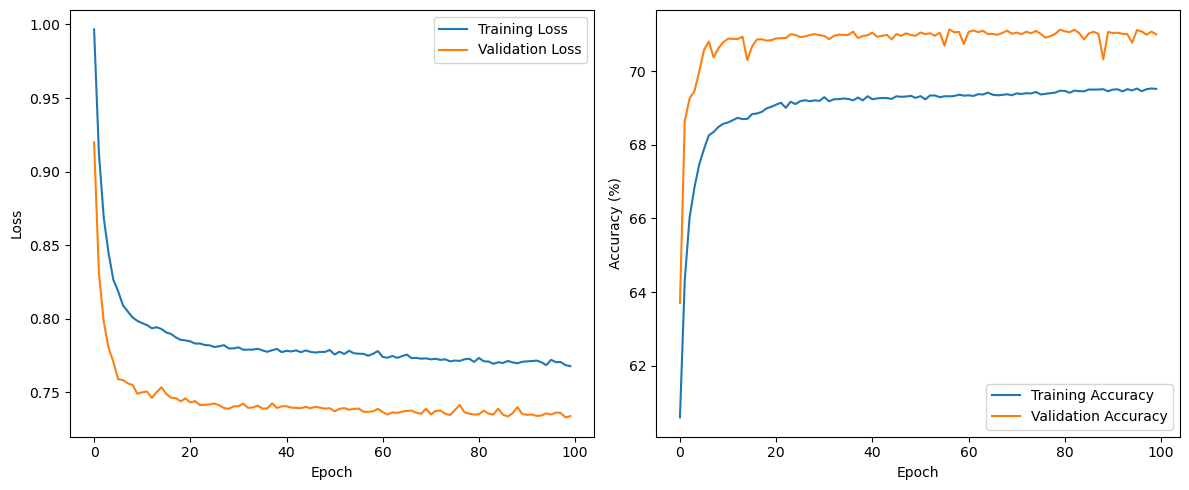

In [11]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Definir el modelo
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(21, 64) # features, o sea X tiene 21 columnas
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4) # 4 categorías de Purchase, o sea 'y' tiene 4 valores posibles
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
n_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validación
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Graficar pérdidas y exactitud
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Punto c) - Modelo de deep learning con embeddings

class EmbeddingNN(nn.Module):
    def __init__(self, num_users, num_products, embedding_dim):
        super(EmbeddingNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.product_embedding = nn.Embedding(num_products, embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim * 2 + 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, user_id, product_id, other_features):
        user_embedded = self.user_embedding(user_id)
        product_embedded = self.product_embedding(product_id)
        
        x = torch.cat([user_embedded, product_embedded, other_features], dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Definir el modelo de embedding, el optimizador y la función de pérdida
num_users = dataset['User_ID'].nunique()
num_products = dataset['Product_ID'].nunique()
embedding_dim = 10

model_embedding = EmbeddingNN(num_users, num_products, embedding_dim)
optimizer = optim.Adam(model_embedding.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# El resto del proceso de entrenamiento es similar al punto b)


In [ ]:
# Punto d) - Función de recomendación basada en embeddings

def recommend_similar_users(user_id, n=5):
    user_embedding = model_embedding.user_embedding(torch.tensor([user_id]))
    
    all_user_embeddings = model_embedding.user_embedding.weight.data
    similarities = torch.cosine_similarity(user_embedding, all_user_embeddings)
    
    top_n_similar_users = similarities.argsort(descending=True)[:n].tolist()
    return top_n_similar_users

# Ejemplo de uso
user_id = 12345
similar_users = recommend_similar_users(user_id, n=5)
print(f"Usuarios con comportamientos de compra similares al usuario {user_id}: {similar_users}")
